

In this notebook, we will implement t-SNE method. The implementation follows pseudo-code from 
[paper](https://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf). 



In [2]:
# import some library or package 
import numpy as np
import matplotlib.pyplot as plt
import struct
import pickle
from os.path import join
from array import array
import platform

## Reading dataset

In [3]:
def read_mnist_dataset(data_filepath, labels_filepath):
    """
    This function will read the mnist dataset from data file and label file which are binary file and return
    data and labels as arrays
    """
    labels = []
    with open(labels_filepath, 'rb') as file:
        magic, size = struct.unpack(">II", file.read(8))
        labels = array("B", file.read())        

    with open(data_filepath, 'rb') as file:
        magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
        image_data = array("B", file.read())        

    data = []
    for i in range(size):
        data.append([0] * rows * cols)
    for i in range(size):
        img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
        img = img.reshape(28, 28)
        data[i][:] = img            

    return data, labels


def read_cifar_dataset(file):
    """
    This function will read cifar dataset and return data and labels as arrays
    """
    with open(file, 'rb') as fo:
        version = platform.python_version_tuple()
        if version[0] == '2':
            dictionary =  pickle.load(fo)
        elif version[0] == '3':
            dictionary =  pickle.load(fo, encoding='latin1')
    data = dictionary['data']
    labels = dictionary['labels']  
    return data, labels


def read_dataset(data_filepath, labels_filepath = None, dataset = "cifar"):
    """
    This function will read both cifar and mnist dataset and return data and lables as array
    :params
        data_filepath: path to data file with mnist dataset or path to batch file with cifar dataser
        labels_filepath: path to label file with mnist, default is None for cifar
        dataset: cifar or mnist (default is cifar)
    :return
        data
        labels
    """
    data = None
    labels = None
    if dataset == "cifar":
        data, labels = read_cifar_dataset(data_filepath)
    elif dataset == "mnist":
        if labels_filepath is None:
            raise SystemError("You need to provide label file path")
        data, labels = read_mnist_dataset(data_filepath, labels_filepath)
    else:
        raise SystemError("We do not support dataset: {}".format(dataset))
    return data, labels

## Main Program

In [4]:
def compute_p(D, gamma):
    p_ji = np.exp(-D.copy() * gamma)
    sum_pji = np.sum(p_ji)
    p_ji = p_ji / sum_pji
    p_ji = np.maximum(p_ji, 1e-12)
    h = -(p_ji @ np.log(p_ji).T)
    return p_ji, h


def pca(X=np.array([]), no_dims=50):
    """
        Runs PCA on the NxD array X in order to reduce its dimensionality to
        no_dims dimensions.
    """

    print("Preprocessing the data using PCA...")
    (n, d) = X.shape
    X = X - np.tile(np.mean(X, 0), (n, 1))
    (l, M) = np.linalg.eig(np.dot(X.T, X))
    Y = np.dot(X, M[:, 0:no_dims])
    return Y


def tsne(X, ndim, perp, iteration, learning_rate, momentum):
    X = pca(X, 50).real
    print("Compute pairwise distances...")

    n, d = X.shape
    D = np.tile(X, (n, 1, 1))
    D = D - np.swapaxes(D, 0, 1)
    D = np.sum(np.square(D), axis=2)
    divisor = np.average(D)
    D = D/divisor

    P = np.zeros((n, n))

    gamma_arr = np.ones(n)
    perp_log = np.log(perp)
    tol = 1e-5

    for i in range(n):
        max_gamma = np.inf
        min_gamma = -np.inf

        (p_ji, h) = compute_p(D[i, np.concatenate((np.arange(i), np.arange(i + 1, n)))], gamma_arr[i])

        h_diff = h - perp_log
        count = 0
        while abs(h_diff) > tol and count < 100:
            if h_diff > 0:
                min_gamma = gamma_arr[i]
                if max_gamma == np.inf or max_gamma == -np.inf:
                    gamma_arr[i] *= 2
                else:
                    gamma_arr[i] = (gamma_arr[i] + max_gamma) / 2
            else:
                max_gamma = gamma_arr[i]
                if min_gamma == np.inf or min_gamma == -np.inf:
                    gamma_arr[i] /= 2
                else:
                    gamma_arr[i] = (gamma_arr[i] + min_gamma) / 2
            p_ji, h = compute_p(D[i, np.concatenate((np.arange(i), np.arange(i + 1, n)))], gamma_arr[i])
            h_diff = h - perp_log
            count += 1
        if (i + 1) % 500 == 0:
            print("Processed {} data points".format(i + 1))

        P[i, np.concatenate((np.arange(i), np.arange(i + 1, n)))] = p_ji

    print("Finish pairwise distances...")
    print("Start fitting process...")

    Y_d = np.zeros((n, ndim))
    Y = np.random.randn(n, ndim)
    gains = np.ones((n, ndim))
    min_gain = 0.1
    Y_derivative = np.zeros((n, ndim))
    P = P + P.T
    P = P / np.sum(P)
    P = P * 4.
    P = np.maximum(P, 1e-12)

    for i in range(iteration):
        D_1 = np.tile(Y, (n, 1, 1))
        D_2 = D_1 - np.swapaxes(D_1, 0, 1)
        D = np.sum(np.square(D_2), axis=2) + 1
        D = 1 / D
        D[range(n), range(n)] = 0
        q = D / np.sum(D)

        q = np.maximum(q, 1e-12)

        Y_derivative = np.tile((P - q) * D, (ndim, 1, 1))
        Y_derivative = np.swapaxes(Y_derivative, 0, 2)
        Y_derivative = np.swapaxes(Y_derivative, 0, 1)
        Y_derivative = Y_derivative * D_2
        Y_derivative = 4 * np.sum(Y_derivative, axis=1)

        gains = (gains * 0.7) * ((Y_derivative > 0) != (Y_d > 0)) + \
                (gains + 0.8) * ((Y_derivative > 0) == (Y_d > 0))
        gains[gains < min_gain] = min_gain
        Y_d = momentum * Y_d + learning_rate * (gains * Y_derivative)
        Y = Y + Y_d
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        if (i + 1) % 100 == 0:
            C = np.sum(P * np.log(P / q))
            print("Iteration %d: error is %f" % (i + 1, C))
        if i == 100:
            P = P / 4.
    return Y

## Visualization 

In [6]:
def tsne_dimension_reduction(data, labels, processing_data = 2500, ndim = 2, perp = 40, iteration = 1000, learning_rate = 400, momentum = 0.8):
    data = np.array(data[0:processing_data])
    labels = np.array(labels[0:processing_data])
    N = data.shape[0]
    data = data.reshape((N,-1))
    print("Start tsne")
    Y = tsne(data, ndim, perp, iteration, learning_rate, momentum)
    return Y, labels
        

'''    
def tsne_visualization(Y, labels, name):
    fig, ax = plt.subplots(figsize = (12,4))
    scatter = ax.scatter(Y[:, 0], Y[:, 1], 20, labels)
    ax.legend(*scatter.legend_elements(), loc="lower left", title="Classes")
    ax.set_title("2D representation of {}".format(name))
    plt.axis("off")
    plt.show()
''' ;

### Load dataset file paths

In [7]:
input_path = 'data'
mnist_data_filepath = join(input_path, 'mnist/t10k-images.idx3-ubyte')
mnist_labels_filepath = join(input_path, 'mnist/t10k-labels.idx1-ubyte')

fa_data_filepath = join(input_path, 'fashion-mnist/train-images-idx3-ubyte')
fa_labels_filepath = join(input_path, 'fashion-mnist/train-labels-idx1-ubyte')

cifar_data_filepath = join(input_path, 'cifar10/cifar-10-batches-py/data_batch_1')

In [8]:
from visualize import visualize_2d, visualize_3d
%matplotlib notebook

### Mnist Dataset

In [29]:
mnist_data, mnist_labels = read_dataset(mnist_data_filepath, mnist_labels_filepath, dataset="mnist")


In [30]:
tsne_mnist_2, tsne_m_label_2 = tsne_dimension_reduction(mnist_data, mnist_labels, ndim=2)

Start tsne
Preprocessing the data using PCA...
Compute pairwise distances...
Processed 500 data points
Processed 1000 data points
Processed 1500 data points
Processed 2000 data points
Processed 2500 data points
Finish pairwise distances...
Start fitting process...
Iteration 100: error is 17.510594
Iteration 200: error is 1.328404
Iteration 300: error is 1.225056
Iteration 400: error is 1.194209
Iteration 500: error is 1.180482
Iteration 600: error is 1.173107
Iteration 700: error is 1.168503
Iteration 800: error is 1.165519
Iteration 900: error is 1.163210
Iteration 1000: error is 1.161418


<IPython.core.display.Javascript object>


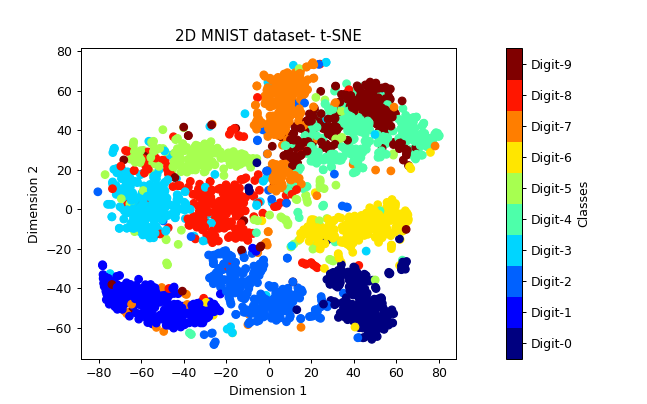

In [31]:
visualize_2d(tsne_mnist_2, tsne_m_label_2, "2D MNIST dataset- t-SNE",["Digit-0", "Digit-1", "Digit-2", "Digit-3", "Digit-4",
                                                    "Digit-5","Digit-6","Digit-7","Digit-8","Digit-9"],"2d_plots/tsne_mnist.png",
            "Dimension 1", "Dimension 2")

In [10]:
tsne_mnist_3, tsne_m_label_3 = tsne_dimension_reduction(mnist_data, mnist_labels, ndim=3)

Start tsne
Preprocessing the data using PCA...
Compute pairwise distances...
Processed 500 data points
Processed 1000 data points
Processed 1500 data points
Processed 2000 data points
Processed 2500 data points
Finish pairwise distances...
Start fitting process...
Iteration 100: error is 17.076211
Iteration 200: error is 1.107971
Iteration 300: error is 1.029655
Iteration 400: error is 1.009206
Iteration 500: error is 1.000567
Iteration 600: error is 0.995682
Iteration 700: error is 0.992166
Iteration 800: error is 0.989897
Iteration 900: error is 0.987879
Iteration 1000: error is 0.986618


In [11]:
from visualize import visualize_2d, visualize_3d
%matplotlib notebook

<IPython.core.display.Javascript object>


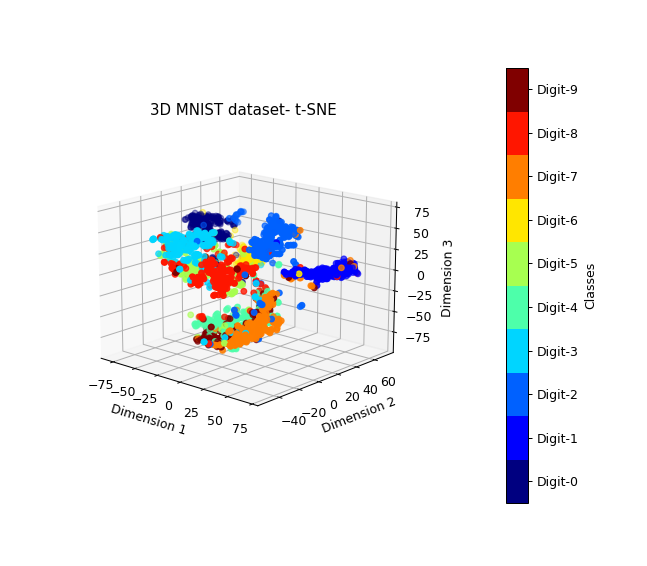

In [12]:

visualize_3d(tsne_mnist_3, tsne_m_label_3,  "3D MNIST dataset- t-SNE",["Digit-0", "Digit-1", "Digit-2", "Digit-3", "Digit-4",
                                                             "Digit-5","Digit-6","Digit-7","Digit-8","Digit-9"],
                                                                    "Dimension 1", "Dimension 2", "Dimension 3")
#plt.savefig("tsne3dmnist.jpg", dpi=400)

### Fashion Mnist Dataset

In [13]:
fashion_data, fashion_labels = read_dataset(fa_data_filepath, fa_labels_filepath, dataset="mnist")

In [26]:
tsne_fashion_2, tsne_f_label_2 = tsne_dimension_reduction(fashion_data, fashion_labels, ndim=2)

Start tsne
Preprocessing the data using PCA...
Compute pairwise distances...
Processed 500 data points
Processed 1000 data points
Processed 1500 data points
Processed 2000 data points
Processed 2500 data points
Finish pairwise distances...
Start fitting process...
Iteration 100: error is 14.462868
Iteration 200: error is 0.992656
Iteration 300: error is 0.913846
Iteration 400: error is 0.892057
Iteration 500: error is 0.882018
Iteration 600: error is 0.876267
Iteration 700: error is 0.872566
Iteration 800: error is 0.869975
Iteration 900: error is 0.868051
Iteration 1000: error is 0.866577


<IPython.core.display.Javascript object>


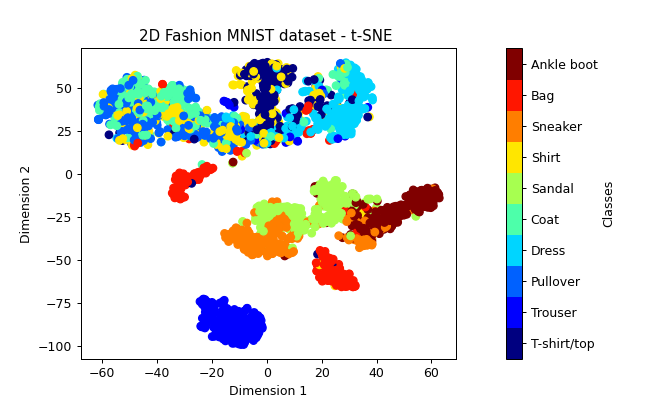

In [27]:
visualize_2d(tsne_fashion_2, tsne_f_label_2, "2D Fashion MNIST dataset - t-SNE ", ["T-shirt/top","Trouser","Pullover","Dress",
                                                                             "Coat","Sandal","Shirt","Sneaker","Bag",
                                                                             "Ankle boot"],"2d_plots/tsne_fashion.png",
                                                                             "Dimension 1", "Dimension 2")

In [14]:
tsne_fashion_3, tsne_f_label_3 = tsne_dimension_reduction(fashion_data, fashion_labels, ndim=3)

Start tsne
Preprocessing the data using PCA...
Compute pairwise distances...
Processed 500 data points
Processed 1000 data points
Processed 1500 data points
Processed 2000 data points
Processed 2500 data points
Finish pairwise distances...
Start fitting process...
Iteration 100: error is 14.060591
Iteration 200: error is 0.856971
Iteration 300: error is 0.780988
Iteration 400: error is 0.760064
Iteration 500: error is 0.750449
Iteration 600: error is 0.745007
Iteration 700: error is 0.741376
Iteration 800: error is 0.738772
Iteration 900: error is 0.736792
Iteration 1000: error is 0.735225


<IPython.core.display.Javascript object>


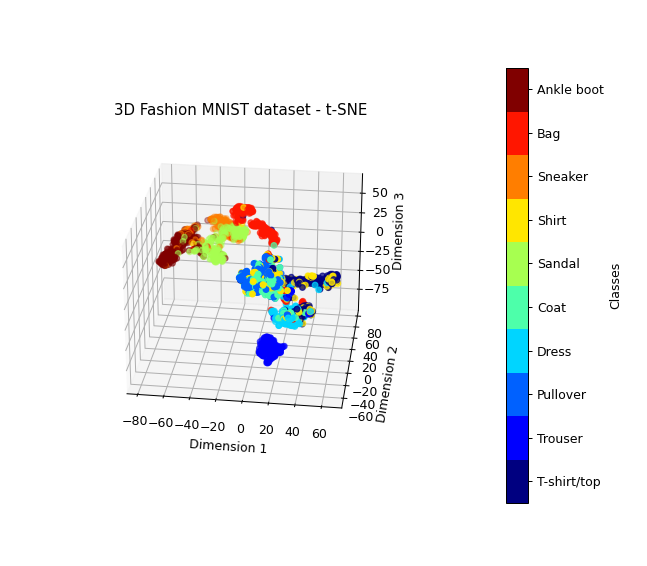

In [15]:
visualize_3d(tsne_fashion_3, tsne_f_label_3, "3D Fashion MNIST dataset - t-SNE ",["T-shirt/top","Trouser","Pullover","Dress",
                                                                             "Coat","Sandal","Shirt","Sneaker","Bag",
                                                                             "Ankle boot"], "Dimension 1", "Dimension 2", 
                                                                                     "Dimension 3")
plt.savefig("tsne3dfmnist.jpg", dpi=600)

### Cifar 10

In [21]:
cifar_data, cifar_labels = read_dataset(cifar_data_filepath)

In [24]:
tsne_cifar_2, tsne_c_label_2 = tsne_dimension_reduction(cifar_data, cifar_labels, ndim=2)

Start tsne
Preprocessing the data using PCA...
Compute pairwise distances...
Processed 500 data points
Processed 1000 data points
Processed 1500 data points
Processed 2000 data points
Processed 2500 data points
Finish pairwise distances...
Start fitting process...
Iteration 100: error is 21.492202
Iteration 200: error is 1.963795
Iteration 300: error is 1.877544
Iteration 400: error is 1.863131
Iteration 500: error is 1.857245
Iteration 600: error is 1.854111
Iteration 700: error is 1.852583
Iteration 800: error is 1.851739
Iteration 900: error is 1.851215
Iteration 1000: error is 1.850875


<IPython.core.display.Javascript object>


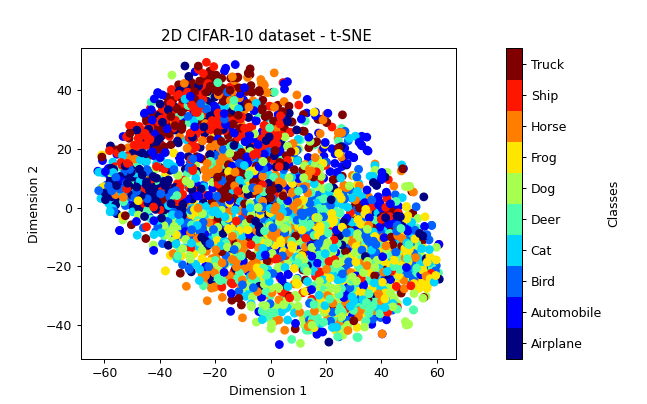

In [25]:
visualize_2d(tsne_cifar_2, tsne_c_label_2, "2D CIFAR-10 dataset - t-SNE ", ["Airplane", "Automobile", "Bird", "Cat", 
                                                                                "Deer","Dog","Frog", "Horse","Ship",
                                                                              "Truck"],"2d_plots/tsne_cifar.png",
                                                                             "Dimension 1", "Dimension 2")

In [22]:
tsne_cifar_3, tsne_c_label_3 = tsne_dimension_reduction(cifar_data, cifar_labels, ndim=3)

Start tsne
Preprocessing the data using PCA...
Compute pairwise distances...
Processed 500 data points
Processed 1000 data points
Processed 1500 data points
Processed 2000 data points
Processed 2500 data points
Finish pairwise distances...
Start fitting process...
Iteration 100: error is 20.022841
Iteration 200: error is 1.659138
Iteration 300: error is 1.603590
Iteration 400: error is 1.592594
Iteration 500: error is 1.588015
Iteration 600: error is 1.585141
Iteration 700: error is 1.583680
Iteration 800: error is 1.582500
Iteration 900: error is 1.581639
Iteration 1000: error is 1.580986


<IPython.core.display.Javascript object>


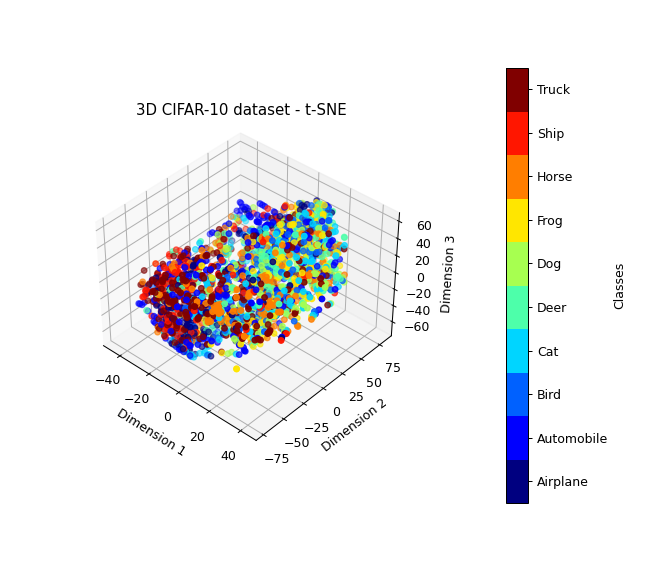

In [23]:
visualize_3d(tsne_cifar_3, tsne_f_label_3, "3D CIFAR-10 dataset - t-SNE ",["Airplane", "Automobile", "Bird", "Cat", 
                                                                                "Deer","Dog","Frog", "Horse","Ship",
                                                                              "Truck"], "Dimension 1", "Dimension 2", 
                                                                                     "Dimension 3")
plt.savefig("tsne3cifar.jpg", dpi=400)